In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

In [6]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_WF_1_24_2023'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [47]:
len(subjects)

17

In [8]:
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [10]:
def load_subject(subject):
    df_mouse = pd.read_csv(data_directory + subject + '/cells150.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    return df_mouse

# Analysis on SWISS WF 1 24 2023

In [11]:
# NB: Run only if file does not exist or needs to be regenerated
dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject), 
                                                                          vol=volumes, 
                                                                          level=8) for subject in subjects}
np.save('dict_results_across_mice_SW_WF_1_24_2023.npy', dict_results_across_mice)

/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/home/stella/anaconda2/lib/pytho

In [12]:
dict_results_across_mice = np.load('dict_results_across_mice_SW_WF_1_24_2023.npy', allow_pickle=True).item()

# List areas with null cell count

In [13]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}

# List areas with no volume

In [14]:
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}

# Divide mice into experimental groups: FAM/UNFAM/CONTROL

In [15]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
experimental_groups

{'Control': ['SW12Control',
  'SW16Control',
  'SW23Control',
  'SW21Control',
  'SW8Control',
  'SW1Control'],
 'Unfam': ['SW14Unfam', 'SW4Unfam', 'SW17Unfam', 'SW7Unfam', 'SW3Unfam'],
 'Fam': ['SW15Fam', 'SW2Fam', 'SW11Fam', 'SW22Fam', 'SW6Fam', 'SW19Fam']}

# Calculate cell count across experimental groups

In [16]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

## Calculate t-tests across groups per area

In [17]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.245411,0.546128,0.73028
1,Primary motor area,0.76571,0.817533,0.962449
2,Secondary motor area,0.797159,0.511934,0.633047
3,Primary somatosensory area,0.739332,0.957996,0.869096
4,Supplemental somatosensory area,0.982775,0.584981,0.633928
...,...,...,...,...
293,Flocculus,0.0428376,0.889858,0.30926
294,Fastigial nucleus,0.558356,0.36545,0.522231
295,Interposed nucleus,0.055114,0.699292,0.379784
296,Dentate nucleus,0.0501437,0.715877,0.37668


In [18]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [19]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Lateral dorsal nucleus of thalamus,0.00541794
Preparasubthalamic nucleus,0.0141646
Edinger-Westphal nucleus,0.0142149
Globus pallidus internal segment,0.0209215
Periventricular hypothalamic nucleus posterior part,0.021606
Dorsal premammillary nucleus,0.026018
Dorsal nucleus raphe,0.0268238
Medial geniculate complex,0.0275783
Reticular nucleus of the thalamus,0.0283928


In [20]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Area postrema,0.0238564
Supragenual nucleus,0.0350926
Caudoputamen,0.0364777
Ventral premammillary nucleus,0.0507981
Medial preoptic nucleus,0.0691183
Nucleus raphe pallidus,0.110752
Edinger-Westphal nucleus,0.114536
Subparaventricular zone,0.115958
Supramammillary nucleus,0.123235


In [21]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Edinger-Westphal nucleus,0.0621346
Suprachiasmatic nucleus,0.106065
Dorsal nucleus raphe,0.106333
Periventricular hypothalamic nucleus preoptic part,0.128815
Lateral habenula,0.141246
Gigantocellular reticular nucleus,0.143456
Subparaventricular zone,0.143894
Paraflocculus,0.148257
Superior central nucleus raphe,0.15533


## Mann Whitney Test for comparison across groups

In [22]:
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_ncells

,area,pval_Control_vs_Fam,pval_Control_vs_Unfam,pval_Fam_vs_Unfam
0,Frontal pole cerebral cortex,0.148553,0.5,0.205124
1,Primary motor area,0.468093,0.392096,0.392096
2,Secondary motor area,0.468093,0.392096,0.463632
3,Primary somatosensory area,0.468093,0.392096,0.463632
4,Supplemental somatosensory area,0.34446,0.463632,0.392096
...,...,...,...,...
293,Flocculus,0.0460626,0.205657,0.46355
294,Fastigial nucleus,0.260555,0.324038,0.261408
295,Interposed nucleus,0.0641026,0.261408,0.392096
296,Dentate nucleus,0.0101203,0.180108,0.463632


In [23]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [24]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Ventral premammillary nucleus,0.00253743
Lateral dorsal nucleus of thalamus,0.00411951
Dorsal premammillary nucleus,0.00653261
Preparasubthalamic nucleus,0.00796829
Periventricular hypothalamic nucleus posterior part,0.0100112
Dentate nucleus,0.0101203
Zona incerta,0.0101203
Ventral part of the lateral geniculate complex,0.0153195
Globus pallidus internal segment,0.0153195


In [25]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Caudoputamen,0.0178819
Supragenual nucleus,0.0216541
Area postrema,0.0225635
Nucleus raphe pallidus,0.024203
Subparaventricular zone,0.0582283
Ammon's horn,0.0603454
Posterior limiting nucleus of the thalamus,0.0603454
Superior olivary complex,0.0603454
Parapyramidal nucleus,0.0825123


In [26]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Pontine reticular nucleus,0.0414187
Edinger-Westphal nucleus,0.0582283
Linear nucleus of the medulla,0.0599231
Inferior salivatory nucleus,0.0711502
Dorsal nucleus raphe,0.0716073
Lingula (I),0.0716073
Superior central nucleus raphe,0.0854518
Medial geniculate complex,0.0854518
Caudoputamen,0.0854518


## Calculate cross corr across groups per area on cell count

In [27]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

## Plot cross corr matrix across groups per area on cell count

Text(0.5, 1.0, 'CONTROL')

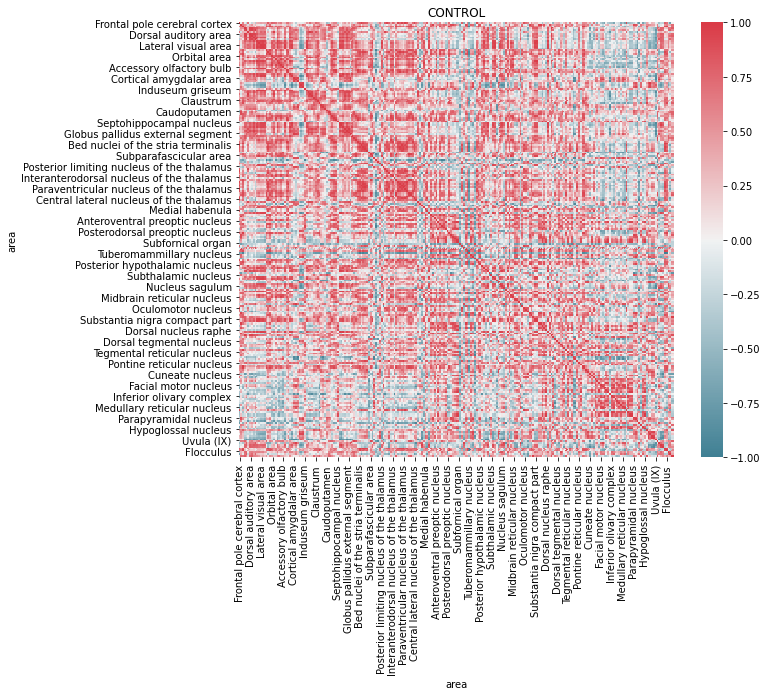

In [28]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

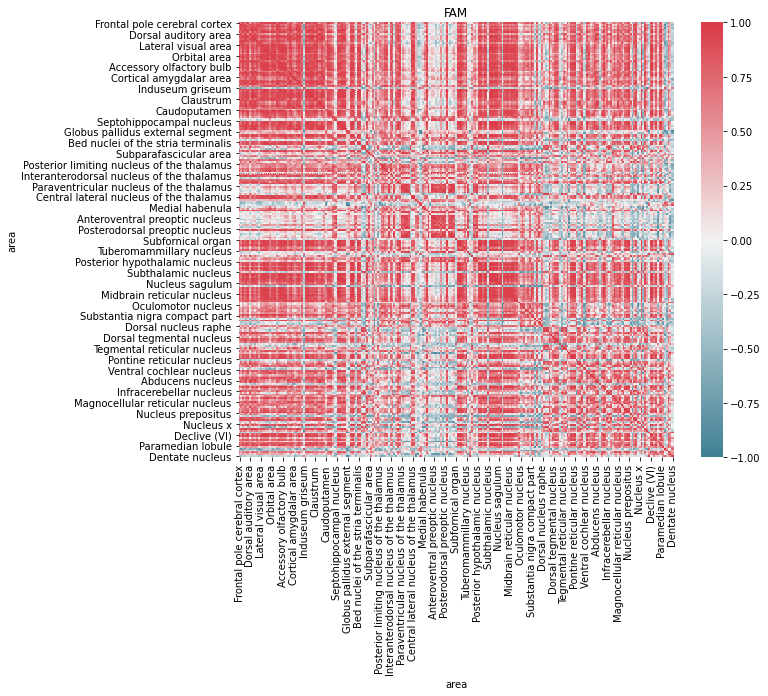

In [29]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

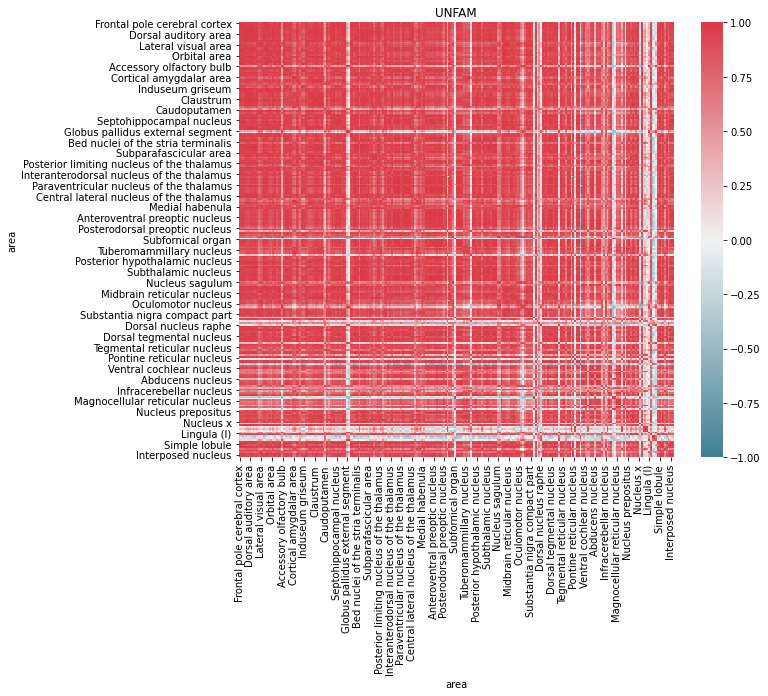

In [30]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

# Calculate energy across experimental groups

In [32]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

## T-test on energy across groups

In [33]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)

In [34]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [35]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Lateral dorsal nucleus of thalamus,0.00445341
Reticular nucleus of the thalamus,0.0151406
Edinger-Westphal nucleus,0.0155237
Globus pallidus internal segment,0.0162873
Dorsal premammillary nucleus,0.0183544
Nodulus (X),0.0189624
Dorsal nucleus raphe,0.0220646
Preparasubthalamic nucleus,0.0230939
Supramammillary nucleus,0.038221


In [36]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Area postrema,0.0262398
Ventral premammillary nucleus,0.0486668
Medial preoptic nucleus,0.0845167
Supragenual nucleus,0.088582
Caudoputamen,0.093657
Nucleus raphe pallidus,0.113639
Dorsal premammillary nucleus,0.116969
Edinger-Westphal nucleus,0.130844
Supramammillary nucleus,0.139187


In [37]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Edinger-Westphal nucleus,0.0512714
Dorsal nucleus raphe,0.0783524
Nucleus raphe pontis,0.0883457
Suprachiasmatic nucleus,0.105387
Pyramus (VIII),0.116448
Anterodorsal nucleus,0.120563
Gigantocellular reticular nucleus,0.121525
Rostral linear nucleus raphe,0.125556
Subparaventricular zone,0.138558


## Mann-Whitney Test across groups

In [38]:
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')

In [39]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [40]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Superior salivatory nucleus,0.00253743
Substantia nigra lateral part,0.00253743
Granular lamina of the cochlear nuclei,0.00253743
Cochlear nucleus subpedunclular granular region,0.00253743
Nucleus z,0.00253743
Accessory abducens nucleus,0.00253743
Efferent vestibular nucleus,0.00253743
Intercollicular nucleus,0.00253743
Efferent cochlear group,0.00253743


In [41]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Pontine reticular nucleus ventral part,0.00405656
Cochlear nucleus subpedunclular granular region,0.00405656
Granular lamina of the cochlear nuclei,0.00405656
Efferent vestibular nucleus,0.00405656
Superior salivatory nucleus,0.00405656
Retroethmoid nucleus,0.00405656
Efferent cochlear group,0.00405656
Lateral tegmental nucleus,0.00405656
Substantia nigra lateral part,0.00405656


In [42]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_mannwhitneyu_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Superior salivatory nucleus,0.00253743
Substantia nigra lateral part,0.00253743
Lateral strip of striatum,0.00253743
Lateral tegmental nucleus,0.00253743
Pontine reticular nucleus ventral part,0.00253743
Suprachiasmatic preoptic nucleus,0.00253743
Granular lamina of the cochlear nuclei,0.00253743
Cochlear nucleus subpedunclular granular region,0.00253743
Anterior hypothalamic area,0.00253743


## Calculate cross corr matrix across experimental groups on energy

In [43]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

## Plot cross corr matrix across groups per area on energy

Text(0.5, 1.0, 'CONTROL')

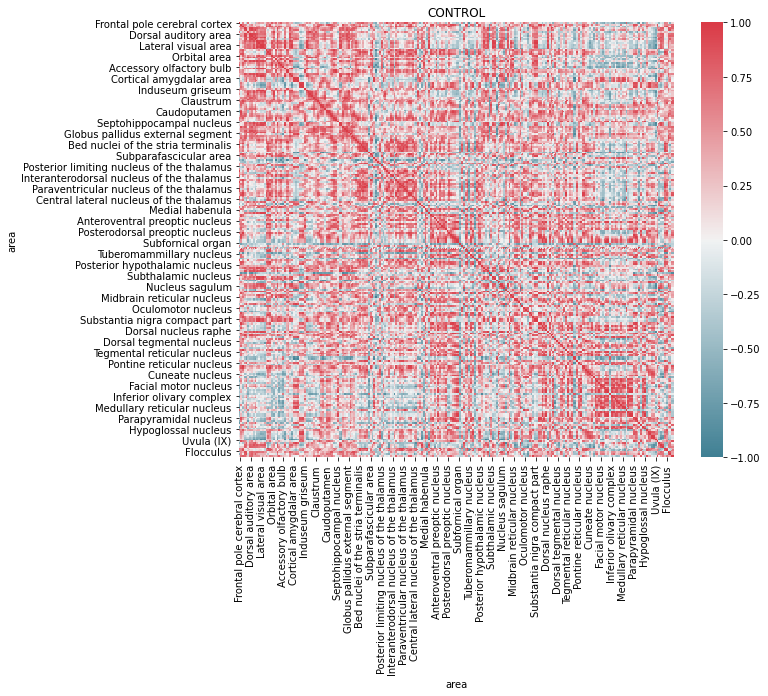

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

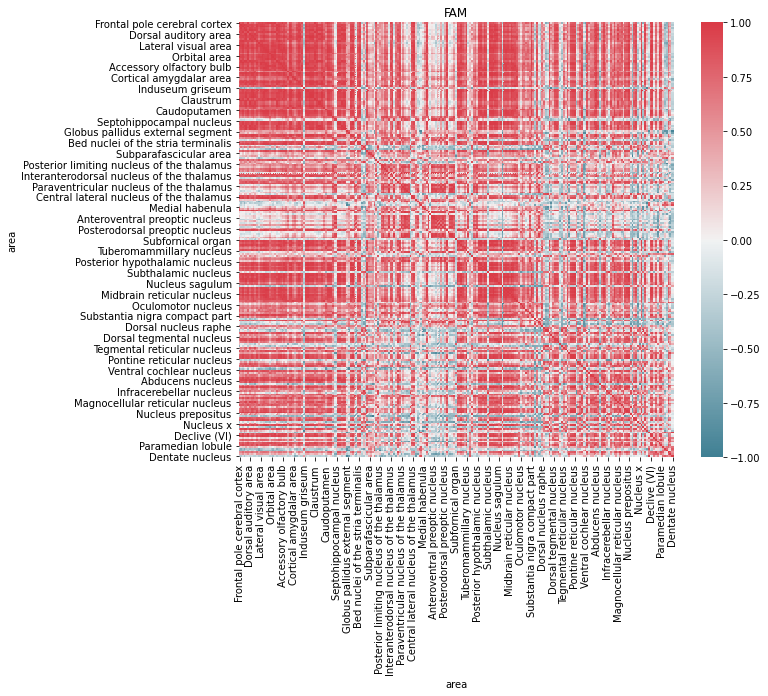

In [45]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

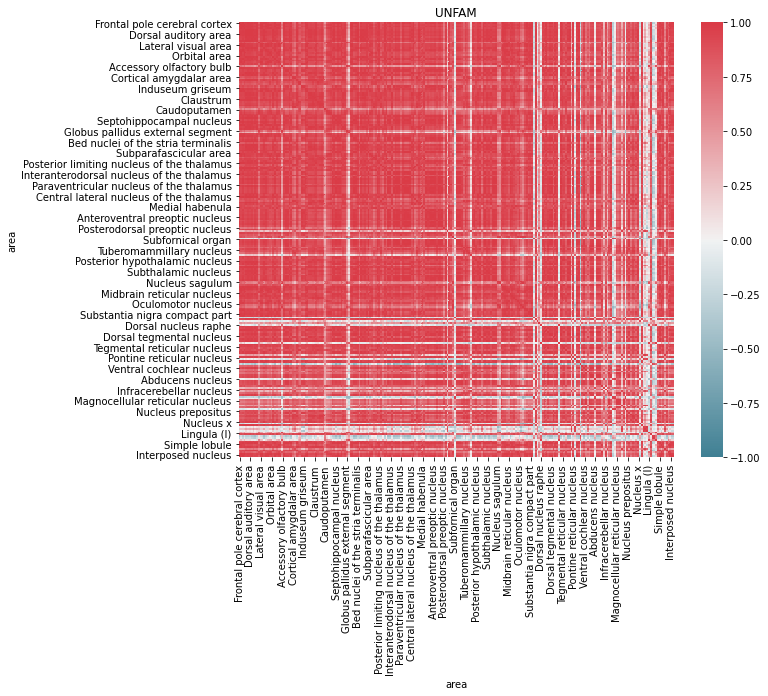

In [46]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')